In [1]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

2025-12-04 04:19:07.616740: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 04:19:07.638343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 04:19:07.638407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 04:19:07.639269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 04:19:07.644062: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# ==============================================================================
# 1. KONFIGURASI
# ==============================================================================
FOLDER_DATA = "/work/open_meteo_climate"
NAMA_FILE = "kebumen_75tahun_lengkap.csv"
PATH_FILE = os.path.join(FOLDER_DATA, NAMA_FILE)

# Label Kelas (Sesuai Request)
CLASSES = {
    0: "☀️ Berawan / Cerah (0 mm)",
    1: "☁️ Hujan Ringan (0.1 - 5 mm)",
    2: "🌧️ Hujan Sedang (5 - 10 mm)",
    3: "⛈️ Hujan Lebat (10 - 20 mm)",
    4: "🚨 Sangat Lebat (> 20 mm)"
}

In [5]:
# ==============================================================================
# 2. LOAD DATA & BERSIHKAN WAKTU
# ==============================================================================
def load_data(filepath):
    print(f"📂 Membaca file: {filepath}")
    if not os.path.exists(filepath):
        print("❌ File tidak ditemukan.")
        return None
    
    # Baca CSV
    df = pd.read_csv(filepath, index_col='date', parse_dates=True)
    
    # Perbaikan Zona Waktu (Agar tidak geser)
    # 1. Baca sebagai UTC
    df.index = pd.to_datetime(df.index, utc=True)
    # 2. Geser ke WIB
    df.index = df.index.tz_convert('Asia/Jakarta')
    # 3. Hapus label zona waktu (biar jadi jam dinding polos)
    df.index = df.index.tz_localize(None)
    
    df = df.sort_index()
    print(f"✅ Data Siap! Rentang: {df.index.min()} s.d {df.index.max()}")
    return df

df = load_data(PATH_FILE)

# Ambil data 10 tahun terakhir agar relevan dan training tidak terlalu lama
# (Silakan ubah tahunnya jika mau lebih banyak data)
df_ai = df.loc['1980':].copy()

📂 Membaca file: /work/open_meteo_climate/kebumen_75tahun_lengkap.csv
✅ Data Siap! Rentang: 1950-01-01 01:00:00 s.d 2025-12-03 23:00:00


In [6]:
# ==============================================================================
# 3. FEATURE ENGINEERING (PEMBAGIAN KELAS)
# ==============================================================================
def categorize_rain(mm):
    """Mengelompokkan curah hujan per jam sesuai standar."""
    if mm < 0.1:   return 0  # Tidak Hujan
    elif mm < 5.0: return 1  # Ringan
    elif mm < 10.0: return 2 # Sedang
    elif mm < 20.0: return 3 # Lebat
    else: return 4           # Sangat Lebat

# Terapkan kategori ke kolom baru
df_ai['target_class'] = df_ai['rain_mm'].apply(categorize_rain)

print("\n📊 Distribusi Data per Kelas:")
print(df_ai['target_class'].value_counts().sort_index())


📊 Distribusi Data per Kelas:
target_class
0    248228
1    152060
2      1959
3       280
4        49
Name: count, dtype: int64


In [7]:
# ==============================================================================
# 4. PRE-PROCESSING (SCALING & WINDOWING)
# ==============================================================================
# Fitur Input (X)
features = ['temperature', 'humidity', 'rain_mm', 'wind_speed', 'pressure']
# Target Output (y)
target = 'target_class'

# Scaling Input (Agar angka 0-1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_ai[features])
y_raw = df_ai[target].values

# Fungsi Sliding Window (Melihat masa lalu)
def create_windows(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

print("\n✂️ Memotong data per 24 jam (Windowing)...")
TIME_STEPS = 24 
X_window, y_window = create_windows(X_scaled, y_raw, TIME_STEPS)

# Split Training (80%) dan Testing (20%)
split_idx = int(len(X_window) * 0.8)
X_train, y_train = X_window[:split_idx], y_window[:split_idx]
X_test, y_test = X_window[split_idx:], y_window[split_idx:]

print(f"Data Latih: {X_train.shape}")
print(f"Data Uji  : {X_test.shape}")


✂️ Memotong data per 24 jam (Windowing)...
Data Latih: (322041, 24, 5)
Data Uji  : (80511, 24, 5)


In [8]:
# --- HITUNG CLASS WEIGHT (PENTING!) ---
# Agar AI tidak meremehkan hujan lebat yang jarang terjadi
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(weights))
print("⚖️ Bobot Penyeimbang Kelas:", class_weights_dict)

⚖️ Bobot Penyeimbang Kelas: {0: 0.3180322040677263, 1: 0.5472699464695386, 2: 40.55931989924433, 3: 305.25213270142183, 4: 2077.6838709677418}


In [9]:
# ==============================================================================
# 5. MEMBANGUN MODEL LSTM
# ==============================================================================
model = Sequential()

# --- LAYER 1: FEATURE EXTRACTION ---
# Unit diperbesar jadi 128 agar bisa menangkap pola cuaca yang rumit
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()) # Menstabilkan aliran data biar belajar lebih cepat
model.add(Dropout(0.3))         # Mematikan 30% neuron secara acak biar gak manja (mencegah overfitting)

# --- LAYER 2: DEEP LEARNING ---
model.add(LSTM(64, return_sequences=True)) # Kita stack lagi LSTM-nya
model.add(BatchNormalization())
model.add(Dropout(0.3))

# --- LAYER 3: SUMMARY ---
model.add(LSTM(32, return_sequences=False)) # Layer LSTM terakhir tidak return sequence
model.add(BatchNormalization())
model.add(Dropout(0.3))

# --- LAYER 4: REASONING (DENSE LAYERS) ---
# Biarkan model "berpikir" dulu sebelum menebak kelas
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))

# --- OUTPUT LAYER ---
model.add(Dense(5, activation='softmax'))

# --- COMPILING DENGAN LEARNING RATE KHUSUS ---
# Kadang default learning rate terlalu cepat/lambat. Kita set manual.
opt = Adam(learning_rate=0.001) 

model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           68608     
                                                                 
 batch_normalization (Batch  (None, 24, 128)           512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0

In [ ]:
# ==============================================================================
# 6. TRAINING (MELATIH OTAK AI)
# ==============================================================================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🚀 Mulai Training...")
history = model.fit(
    X_train, y_train,
    epochs=20,           
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weights_dict, # Wajib pakai ini
    callbacks=[early_stop],
    verbose=1
)

# Plot History Belajar
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Pembelajaran Model')
plt.legend()
plt.show()


🚀 Mulai Training...
Epoch 1/20
4529/4529 [==============================] - 109s 23ms/step - loss: 1.7027 - accuracy: 0.3235 - val_loss: 0.6892 - val_accuracy: 0.6669
Epoch 2/20
2530/4529 [===============>..............] - ETA: 45s - loss: 1.7260 - accuracy: 0.2370


📊 EVALUASI MODEL:
1421/1421 [==============================] - 4s 2ms/step
                              precision    recall  f1-score   support

   ☀️ Berawan / Cerah (0 mm)       0.00      0.00      0.00     25345
☁️ Hujan Ringan (0.1 - 5 mm)       0.00      0.00      0.00     19807
 🌧️ Hujan Sedang (5 - 10 mm)       0.01      1.00      0.01       246
 ⛈️ Hujan Lebat (10 - 20 mm)       0.00      0.00      0.00        36
    🚨 Sangat Lebat (> 20 mm)       0.00      0.00      0.00        13

                    accuracy                           0.01     45447
                   macro avg       0.00      0.20      0.00     45447
                weighted avg       0.00      0.01      0.00     45447

/root/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

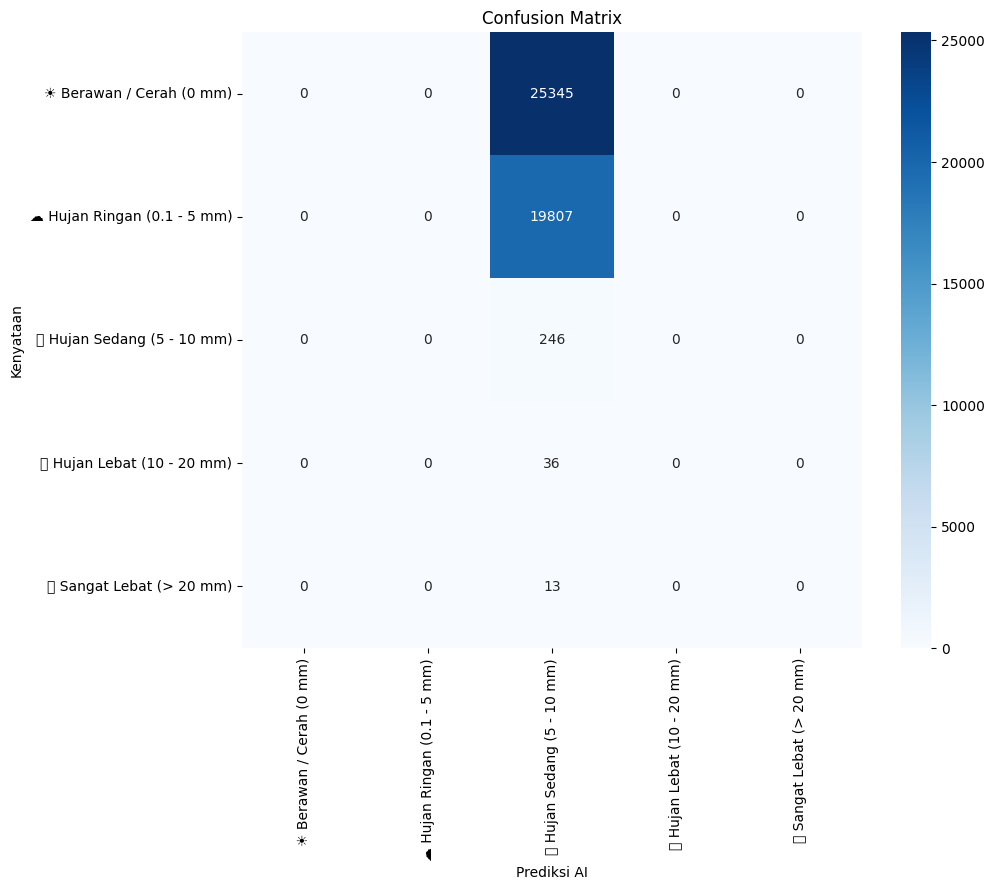

In [27]:
# ==============================================================================
# 7. EVALUASI HASIL
# ==============================================================================
print("\n📊 EVALUASI MODEL:")
y_pred_prob = model.predict(X_test)
y_pred_class = np.argmax(y_pred_prob, axis=1)

target_names = [CLASSES[i] for i in range(5)]
print(classification_report(y_test, y_pred_class, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi AI')
plt.ylabel('Kenyataan')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# ==============================================================================
# 8. DEMO PREDIKSI (KARTU CUACA)
# ==============================================================================
def tampilkan_kartu_prediksi(input_24jam):
    """Menampilkan prediksi dengan gaya persentase."""
    input_reshaped = input_24jam.reshape(1, TIME_STEPS, len(features))
    probs = model.predict(input_reshaped, verbose=0)[0]
    
    pred_idx = np.argmax(probs)
    confidence = probs[pred_idx] * 100
    
    print("\n" + "="*50)
    print(f"🔮 PREDIKSI CUACA (1 Jam Kedepan)")
    print("="*50)
    
    print(f"Hasil Utama    : {CLASSES[pred_idx]}")
    print(f"Tingkat Yakin  : {confidence:.1f}%")
    print("-" * 50)
    
    print("Probabilitas:")
    for idx, label in CLASSES.items():
        score = probs[idx] * 100
        bar = "█" * int(score / 4)
        marker = "👈" if idx == pred_idx else ""
        print(f"{label:<30} : {score:>5.1f}% | {bar} {marker}")
    print("="*50)

# Coba cari data yang aslinya Hujan Lebat (Kelas 3 atau 4) untuk dites
print("\n🧪 DEMO HASIL PADA DATA BADAI:")
badai_indices = np.where(y_test >= 3)[0] # Cari kelas 3 atau 4

if len(badai_indices) > 0:
    # Ambil satu contoh
    sample_idx = badai_indices[0]
    tampilkan_kartu_prediksi(X_test[sample_idx])
else:
    print("Tidak ada data badai di set pengujian untuk didemokan.")


🧪 DEMO HASIL PADA DATA BADAI:

🔮 PREDIKSI CUACA (1 Jam Kedepan)
Hasil Utama    : 🌧️ Hujan Sedang (5 - 10 mm)
Tingkat Yakin  : 21.7%
--------------------------------------------------
Probabilitas:
☀️ Berawan / Cerah (0 mm)      :  21.1% | █████ 
☁️ Hujan Ringan (0.1 - 5 mm)   :  20.5% | █████ 
🌧️ Hujan Sedang (5 - 10 mm)    :  21.7% | █████ 👈
⛈️ Hujan Lebat (10 - 20 mm)    :  19.8% | ████ 
🚨 Sangat Lebat (> 20 mm)       :  16.9% | ████ 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=672c3bf7-b636-46e8-b7c0-4f6feec29313' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>